# Frowning upon Bias: Exposing the Impact of Race on Emotion Classification

Project mentor: Mark Dredze

Team Members: Kesavan Venkatesh (kvenka10), David Lu (dlu17), Rishi Chandra (rchand18), Liam Wang (wwang136)

https://github.com/Lu-David/frowning-bias

# Outline and Deliverables

### Uncompleted Deliverables
1. "Would like to accomplish #1": Compare the per-race accuracy results of our facial expression model with facial expression models of other popular facial expression models.

We chose to not pursue this objective as we shifted our project towards improving the fairness of our own model instead of comparing fairness to existing models. We started with a baseline model and then explored a variety of techniques to attempt to improve model fairness.


### Completed Deliverables
1. "Must Accomplish #1": Determine the approximate race distribution of at least one popular facial expression dataset.
2. "Must Accomplish #2": Perform hyperparameter search to tune model with high overall accuracy.
3. "Must Accomplish #3": Train an effective model for facial expression classification using a popular facial expression dataset without stratification by race.
4. "Must Accomplish #4": Compare overall model accuracy on the dataset with the model accuracy on subsets of the dataset broken down by race.
5. "Expect to accomplish #1" Re-train our facial expression model using a stratified train/test split (same distribution in train vs test set) by race and compare overall and per-race model accuracy.
6. "Expect to accomplish #2" Re-train our facial expression model using a stratified train/test split and stratified sampling within groups (same number of each category in each set) by race and compare overall and per-race model accuracy.
7. "Expect to accomplish #3" Perform analysis on model accuracy on the train/test set when broken down by race and facial expression to identify which facial expressions are most likely to be misclassified when considering the distribution of race.
8. "Would like to accomplish #3" Introduce additional dependent variables to compare accuracy across, such as gender or age.

9. "Must complete #1": We discuss our dataset pre-processing [in "Dataset" below](#scrollTo=zFq-_D0khnhh&line=10&uniqifier=1).
10. "Must complete #2": We discuss training our logistic regression baseline [in "Baselines" below](#scrollTo=oMyqHUa0jUw7&line=5&uniqifier=1).
<span style="color:red">TODO: write a blurb for each bullet point</span>.


### Additional Deliverables
1. We introduced data augmentation to see if varying lighting conditions would make the model more agnostic to demographic characteristics. We discuss this in "Data Augmentation" section below.
2. We trained an "Attribute Aware" model that takes demographic information as an input to see if this would make the model more fair. We discuss this in "Attribute Aware Model" section below.

# Preliminaries

## What problem were you trying to solve or understand?

What are the real-world implications of this data and task?

How is this problem similar to others we’ve seen in lectures, breakouts, and homeworks?

What makes this problem unique?

What ethical implications does this problem have?

<span style="color:red">TODO: write a paragraph about this based on the intro</span>.

## Dataset

We used the Real-world Affective Faces Database (RAF-DB) dataset. This dataset consisted of roughly 30,000 images of center-cropped human faces. Each face was labeled with an expression (7 classes: angry, disgusted, fearful, happy, sad, surprised, neutral) along with three demographic attributes: race (Caucasian, African American, Asian), age (0-3, 4-19, 20-39, 40-69, 70+), and gender (Male, Female, Unsure (i.e. the gender is not discernable from the image)). Annotations were made by 40 independent human annotators. 

The task we studied in this project was multi-class classification. The target label was the expression label, and the provided input was the image along with the race, age, and gender annotation.

In our project, we chose to use all three demographic attributes in our fairness analysis. Initially, our project was focused on race; however, as we will later display, our baseline CNN showed interesting biases when intersecting all three of these conditions.


Below, we provide code to setup a local environment. 

In [1]:
# # Run this cell if using google colab
# from google.colab import drive
#
# %cd /content
# ! rm -rf frowning-bias
# ! git clone https://github.com/Lu-David/frowning-bias -b main
# %cd  frowning-bias

In [2]:
# from download_data import download_raf

# download_raf()

In [3]:
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# 	Gender
# 	0: male		1: female	2: unsure
#    ----------------------------------------------------------------------
# 	Race
# 0: Caucasian		1: African-American		2: Asian
# ----------------------------------------------------------------------
# 	Age (5 ranges)
# 0: 0-3	 1: 4-19		2: 20-39		3: 40-69		4: 70+
# NOTE: raw txt file has emotion labels 1-indexed, I am shifting to zero-indexing
emotion_lookup = {
    0: "Surprise",
    1: "Fear",
    2: "Disgust",
    3: "Happiness",
    4: "Sadness",
    5: "Anger",
    6: "Neutral"
}

race_lookup = {
    0: "Caucasian",
    1: "African-American",
    2: "Asian"
}

gender_lookup = {
    0: "Male",
    1: "Female",
    2: "Unsure"
}

age_lookup = {
    0: "0-3",
    1: "4-19",
    2: "20-39",
    3: "40-69",
    4: "70+"
}

# Construct dataframe for train/test data attributes
data_dir = Path("./data")
raf_dir = data_dir / "RAF"
train_dir = raf_dir / "aligned_train"
test_dir = raf_dir / "aligned_test"
annot_dir = raf_dir / "manual"
labels_file = raf_dir / "list_partition_label.txt"
df = pd.read_csv(labels_file, sep=" ", header=None)
df.columns = ["Name", "Emotion"]
df["Path"] = df["Name"].apply(lambda x: os.path.join(str(train_dir), x.replace(".jpg","_aligned.jpg")) if ("train" in x) else os.path.join(str(test_dir), x.replace(".jpg","_aligned.jpg")))
df["Split"] = df["Name"].apply(lambda x: "Train" if ("train" in x) else "Test")
gender = []
race = []
age = []
for i,r in df.iterrows():
    annot_file = os.path.join(str(annot_dir), "{}_manu_attri.txt".format(r["Name"].replace(".jpg","")))
    with open(annot_file, "r") as f:
        lines = f.readlines()
        gender.append(int(lines[5]))
        race.append(int(lines[6]))
        age.append(int(lines[7]))
df["Gender"] = gender
df["Race"] = race
df["Age"] = age
# NOTE: raw txt file has emotion labels 1-indexed, I am shifting to zero-indexing
df["Emotion"] = df["Emotion"] - 1
df["EmotionLabel"] = df["Emotion"].apply(lambda x: emotion_lookup[x])
df["RaceLabel"] = df["Race"].apply(lambda x: race_lookup[x])
df["GenderLabel"] = df["Gender"].apply(lambda x: gender_lookup[x])
df["AgeLabel"] = df["Age"].apply(lambda x: age_lookup[x])
df_train = df[df["Split"]=="Train"]
df_test = df[df["Split"]=="Test"]
assert len(df) == len(df_train) + len(df_test)

data/RAF/aligned_test/test_1396_aligned.jpg


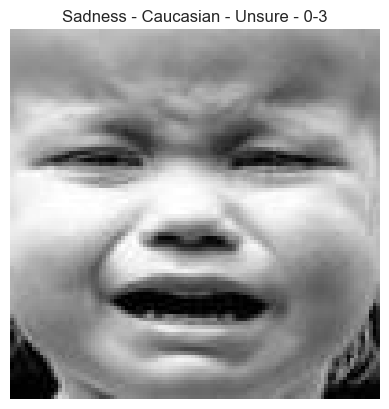

data/RAF/aligned_train/train_08192_aligned.jpg


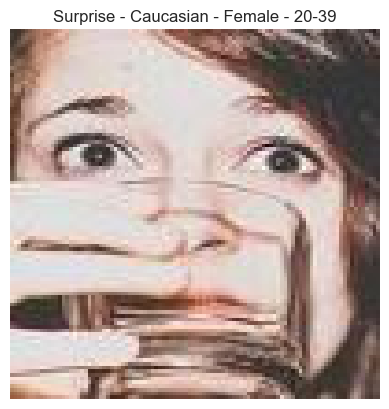

In [5]:
from PIL import Image
from numpy.random import RandomState

random_state = RandomState(1)
samples = df.sample(2, random_state=random_state)
for i in range(len(samples)):
    sample = samples.iloc[i]
    img = Image.open(sample["Path"])
    print(sample["Path"])
    plt.imshow(img)
    plt.title(f"{sample['EmotionLabel']} - {sample['RaceLabel']} - {sample['GenderLabel']} - {sample['AgeLabel']}")
    # hide the axes
    plt.axis('off')
    plt.show()


We can see from these sample images that the RAF-DB dataset is diverse in terms of the lighting conditions, occlusions, head poses, and even post-processing routines applied onto the images.

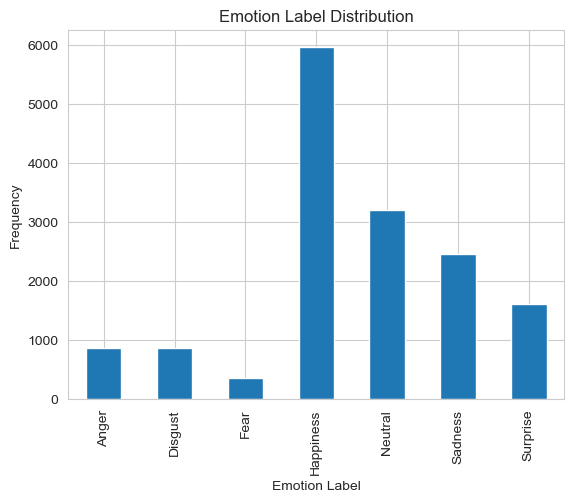

In [6]:
# Distribution of emotion labels
fig, ax = plt.subplots()
ax.set_title("Emotion Label Distribution")
ax.set_xlabel("Emotion Label")
ax.set_ylabel("Frequency")
df["EmotionLabel"].value_counts().sort_index().plot(ax=ax, kind='bar')
plt.show()

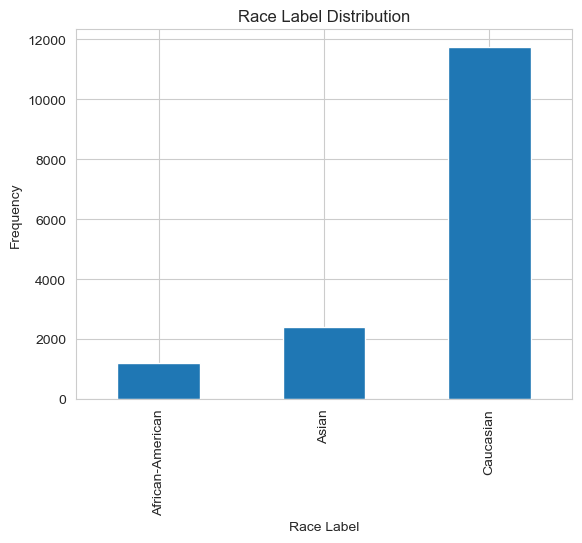

In [7]:
fig, ax = plt.subplots()
ax.set_title("Race Label Distribution")
ax.set_xlabel("Race Label")
ax.set_ylabel("Frequency")
df["RaceLabel"].value_counts().sort_index().plot(ax=ax, kind='bar')
plt.show()

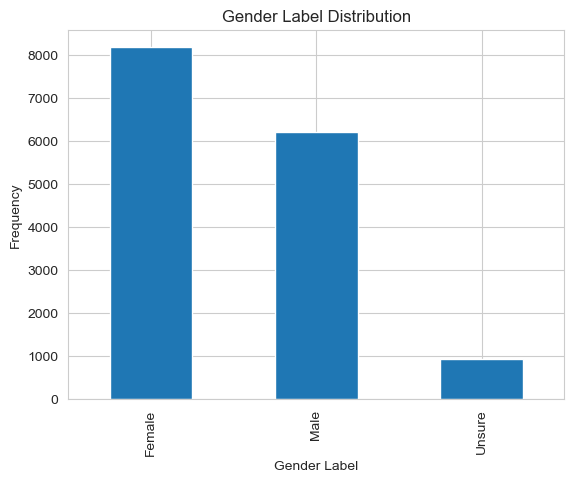

In [8]:
fig, ax = plt.subplots()
ax.set_title("Gender Label Distribution")
ax.set_xlabel("Gender Label")
ax.set_ylabel("Frequency")
df["GenderLabel"].value_counts().sort_index().plot(ax=ax, kind='bar')
plt.show()

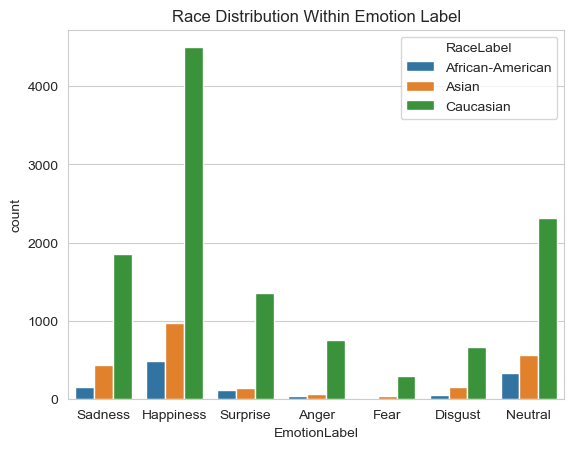

In [9]:
# Distribution of race within each emotion label
race_label_order = ["African-American", "Asian", "Caucasian"]
fig, ax = plt.subplots()
ax.set_title("Race Distribution Within Emotion Label")
sns.countplot(data=df, x="EmotionLabel", hue="RaceLabel", hue_order=race_label_order, ax=ax)
plt.show()

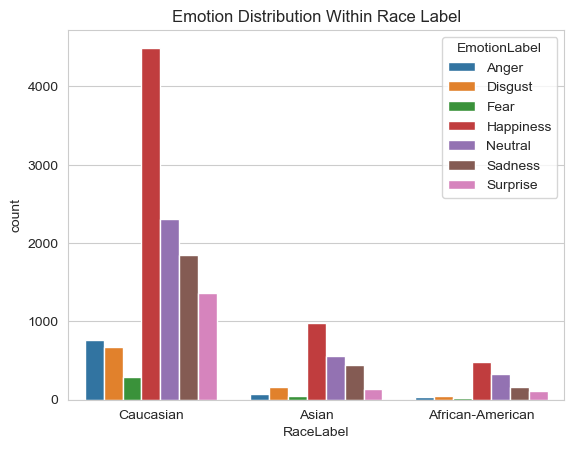

In [10]:
# Distribution of emotion within each race label
emotion_label_order = [emotion_lookup[i] for i in range(7)]
emotion_label_order.sort()
fig, ax = plt.subplots()
ax.set_title("Emotion Distribution Within Race Label")
sns.countplot(data=df, x="RaceLabel", hue="EmotionLabel", hue_order=emotion_label_order, ax=ax)
plt.show()

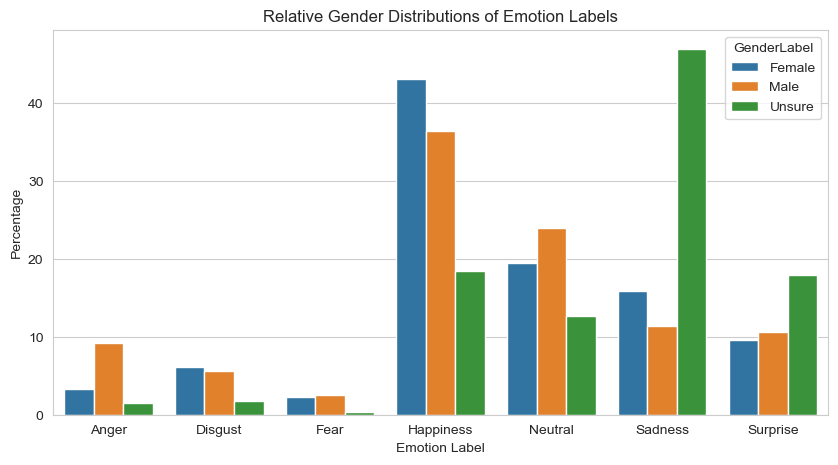

In [11]:
# normalize total number of each emotion label to 100% to show the relative gender distributions
df_test_gender_emotion_count = df.groupby(["GenderLabel", "EmotionLabel"]).size().reset_index(name="Count")
df_test_gender_emotion_count["Percentage"] = df_test_gender_emotion_count.groupby("GenderLabel", group_keys=False)["Count"].apply(lambda x: x / x.sum() * 100)
df_test_gender_emotion_count = df_test_gender_emotion_count.sort_values(by=["GenderLabel", "EmotionLabel"])

# plot the relative gender distributions
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x="EmotionLabel", y="Percentage", hue="GenderLabel", data=df_test_gender_emotion_count, ax=ax)
ax.set_title("Relative Gender Distributions of Emotion Labels")
ax.set_xlabel("Emotion Label")
ax.set_ylabel("Percentage")
plt.show()

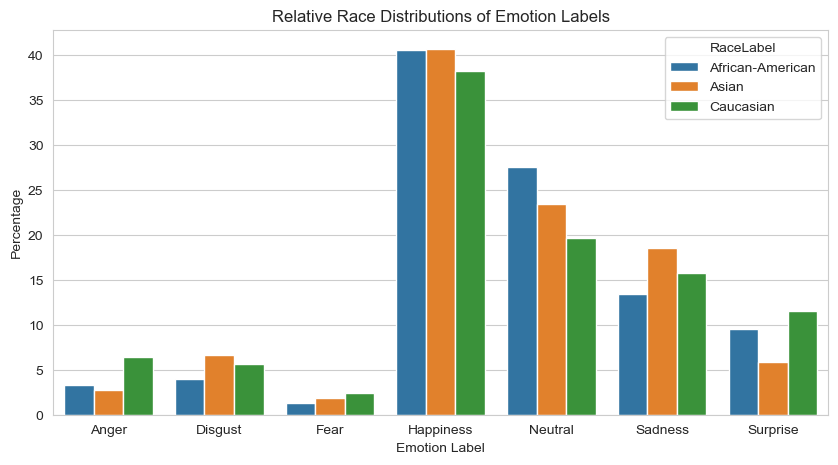

In [12]:
# normalize total number of each emotion label to 100% to show the relative gender distributions
df_test_race_emotion_count = df.groupby(["RaceLabel", "EmotionLabel"]).size().reset_index(name="Count")
df_test_race_emotion_count["Percentage"] = df_test_race_emotion_count.groupby("RaceLabel", group_keys=False)["Count"].apply(lambda x: x / x.sum() * 100)
df_test_race_emotion_count = df_test_race_emotion_count.sort_values(by=["RaceLabel", "EmotionLabel"])

# plot the relative gender distributions
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x="EmotionLabel", y="Percentage", hue="RaceLabel", data=df_test_race_emotion_count, ax=ax)
ax.set_title("Relative Race Distributions of Emotion Labels")
ax.set_xlabel("Emotion Label")
ax.set_ylabel("Percentage")
plt.show()

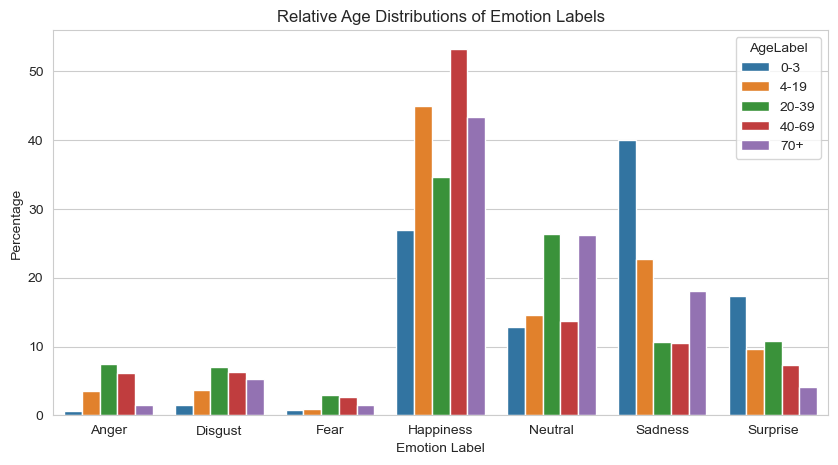

In [13]:
# normalize total number of each emotion label to 100% to show the relative age distributions
age_label_order = [age_lookup[i] for i in range(5)]
df_test_age_emotion_count = df.groupby(["AgeLabel", "EmotionLabel"]).size().reset_index(name="Count")
df_test_age_emotion_count["Percentage"] = df_test_age_emotion_count.groupby("AgeLabel", group_keys=False)["Count"].apply(lambda x: x / x.sum() * 100)
df_test_age_emotion_count = df_test_age_emotion_count.sort_values(by=["AgeLabel", "EmotionLabel"])

# Distribution of gender within each emotion label
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x="EmotionLabel", y="Percentage", hue="AgeLabel", data=df_test_age_emotion_count, ax=ax, hue_order=age_label_order)
ax.set_title("Relative Age Distributions of Emotion Labels")
ax.set_xlabel("Emotion Label")
ax.set_ylabel("Percentage")
plt.show()

<span style="color:red">TODO: write a blurb for these figures and argue why we dropped 0-3 & 70+ and Unsure gender.</span>.

<span style="color:red">TODO: write a blurb about NIMA analysis [David].</span>.

## Pre-processing

As mentioned previously, we chose to use both the image and all three demographic attributes in our analysis. Therefore, our dataset looked like:

$$D = \{\dots, ((x_i, a_i),y_i), \dots\}$$

The target label, emotion expression, was categorical and not balanced. The EDA revealed that the class labels were skewed towards happiness, sadness, and neutral. We handle this during model training by incorporting class weights into the loss function.

We did not have missing data, but we did notice that some "demographic subgroups" were not present in our dataset. See the output below.

In [14]:
for r in range(3):
    for g in range(3):
        for a in range(5):
            count = len(df[(df["Race"]==r) & (df["Gender"]==g) & (df["Age"]==a)])
            print(f"{race_lookup[r]}, {gender_lookup[g]}, {age_lookup[a]}: {count}")

Caucasian, Male, 0-3: 296
Caucasian, Male, 4-19: 732
Caucasian, Male, 20-39: 2288
Caucasian, Male, 40-69: 1179
Caucasian, Male, 70+: 232
Caucasian, Female, 0-3: 172
Caucasian, Female, 4-19: 977
Caucasian, Female, 20-39: 4208
Caucasian, Female, 40-69: 888
Caucasian, Female, 70+: 112
Caucasian, Unsure, 0-3: 584
Caucasian, Unsure, 4-19: 54
Caucasian, Unsure, 20-39: 17
Caucasian, Unsure, 40-69: 1
Caucasian, Unsure, 70+: 2
African-American, Male, 0-3: 178
African-American, Male, 4-19: 173
African-American, Male, 20-39: 168
African-American, Male, 40-69: 80
African-American, Male, 70+: 11
African-American, Female, 0-3: 11
African-American, Female, 4-19: 169
African-American, Female, 20-39: 217
African-American, Female, 40-69: 70
African-American, Female, 70+: 9
African-American, Unsure, 0-3: 108
African-American, Unsure, 4-19: 7
African-American, Unsure, 20-39: 1
African-American, Unsure, 40-69: 0
African-American, Unsure, 70+: 0
Asian, Male, 0-3: 46
Asian, Male, 4-19: 230
Asian, Male, 20-39

We dealt with these missing subgroups by amending our fairness analysis. Specifically, when evaluating fairness
- we ignored images labeled "Unsure" since these were mostly images of babies that annotators apparently struggled to discern the gender of,
- we ignored images labeled "0-3" or "70+" since they were sparsely available in our dataset and did not reflect populations of interest for our project's broader goal/application.

We preprocessed all the data using standard ImageNet transforms. Each image was loaded to be in range [0,1] and normalized using the ImageNet mean and standard deviation. Images are resized from 100x100 to 224x224.

In [15]:
import numpy as np
import torchvision
from torchvision.transforms import ToTensor, Resize, Normalize, RandomInvert

img_size = 224
transform = torchvision.transforms.Compose([ToTensor(), Resize(img_size), Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

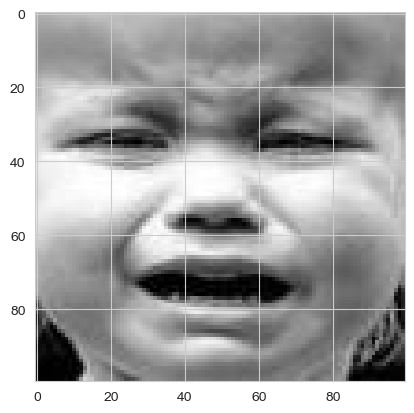

In [16]:
import matplotlib.pyplot as plt
sample_path = "data/RAF/aligned_test/test_1396_aligned.jpg"
sample_image = Image.open(sample_path).convert("RGB")
plt.imshow(sample_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


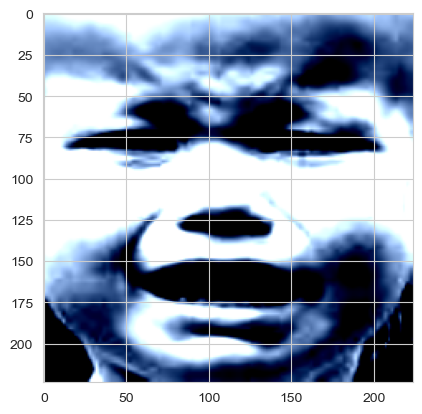

In [17]:
sample_image = transform(sample_image)
sample_image_np = sample_image.numpy().transpose((1,2,0))
plt.imshow(sample_image_np)

We show how this transform affected the mean pixel value per image and per image standard deviation distribution.

In [18]:
pre_transform_means = []
pre_transform_stds = []
post_transform_means = []
post_transform_stds = []
for path in df["Path"]:
    im = Image.open(path).convert("RGB")
    pre_transform_means.append(np.mean(im))
    pre_transform_stds.append(np.std(im))
    post_im = transform(im)
    post_im = post_im.numpy()
    post_transform_means.append(np.mean(post_im))
    post_transform_stds.append(np.std(post_im))

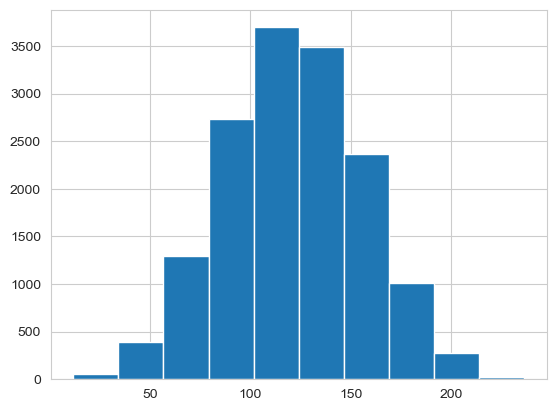

In [19]:
plt.hist(pre_transform_means)
plt.show()

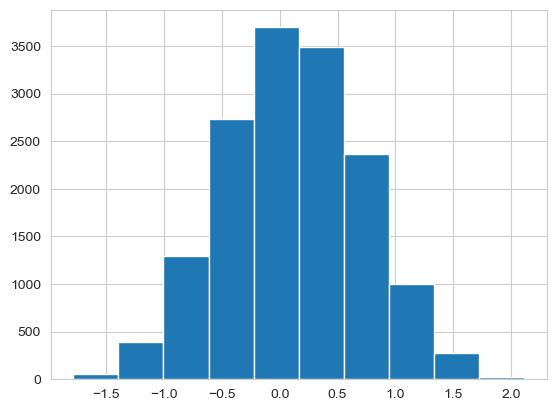

In [20]:
plt.hist(post_transform_means)
plt.show()

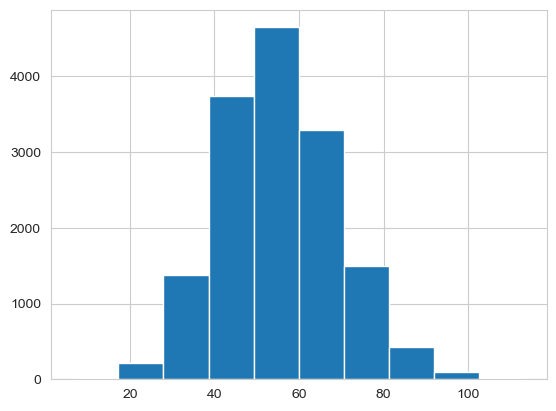

In [21]:
plt.hist(pre_transform_stds)
plt.show()

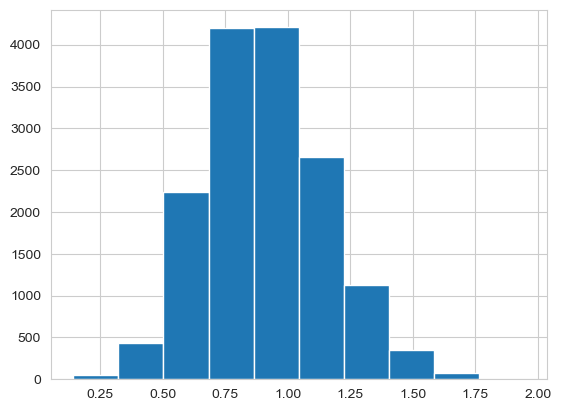

In [22]:
plt.hist(post_transform_stds)
plt.show()

# Models and Evaluation

## Experimental Setup

We evaluated the performance of our trained CNN emotion classifiers on two fronts. We first looked at pure scoring/accuracy metrics:
- accuracy
- AUROC
- F1
These metrics allowed us to sanity-check that our model was learning and make comparisons to performance statistics to state-of-the-art emotion classifiers on RAF-DB. Recall that AUROC is the area under the TPR vs FPR curve (we used a one-vs-all generalization for multiple classes), and F1 score is a metric that captures both the precision and recall of a model's predictions. Using F1 is particularly important for this problem due to the obvious class imbalances present in the dataset.

For fairness, we used equalized opportunity to capture differences in classification performance by demographics. Recall for a binary classifier, equalized opportunity requires that

$$P(R=1|Y=1,A=a_1) = P(R=1|Y=1,A=b).$$

We use the generalization presented by Xu et. al:

$$F = \frac{1}{\sum_{c=1}^{C}{p(\hat{y}=c|y=c,s=d,x)}} \min_{k} {\sum_{c=1}^{C}{p(\hat{y}=c|y=c,s=s_k,x)}}.$$

We select $d$ via

$$d = \text{argmax}_{k} {\sum_{c=1}^{C}{p(\hat{y}=c|y=c,s=s_k,x)}}.$$

Equalized opportunity ensures that the probability of a positive prediction given that the true label is positive is the same across all demographic subgroups. The Xu et. al. equation works by assigning an opportunity score to each demographic group by summing the probability of a positive prediction given that the true label is positive across all classes. The demographic group with the highest opportunity score is then selected as the reference group, "d". The fairness score is then calculated by taking the minimum of the opportunity scores across all demographic groups and dividing by the opportunity score of the reference group. This results in a score ranging from zero to one, where higher is better. A score of one indicates that all demographic groups have the same opportunity score.

We used the cross-entropy loss function with class weights that account for class imbalance. We also modified this loss function in different methods we implemented/tried in order to improve fairness. This will be discussed subsequently in full detail.

We used the provided train/test split for model training and evaluation. For the hyperparameter search, we split our training set further, creating a validation set that we used for early stopping/performance comparisons. The validation split was made at the 80/20 level.

In [23]:
# Code for loss functions: see lines 173-184 in train_all.py
# Code for train/test split: see split.py

SyntaxError: invalid syntax (3388967647.py, line 1)

## Baselines 

We trained a baseline ResNet18 model to do emotion classification. We chose this model since it was popularly used for classification on RAF-DB and is a robust CNN architecture that is good at avoiding the vanishing gradient problem (due to residual blocks that create "highways" for gradient flow).

Below is the leaderboard for classification accuracy on RAF-DB.
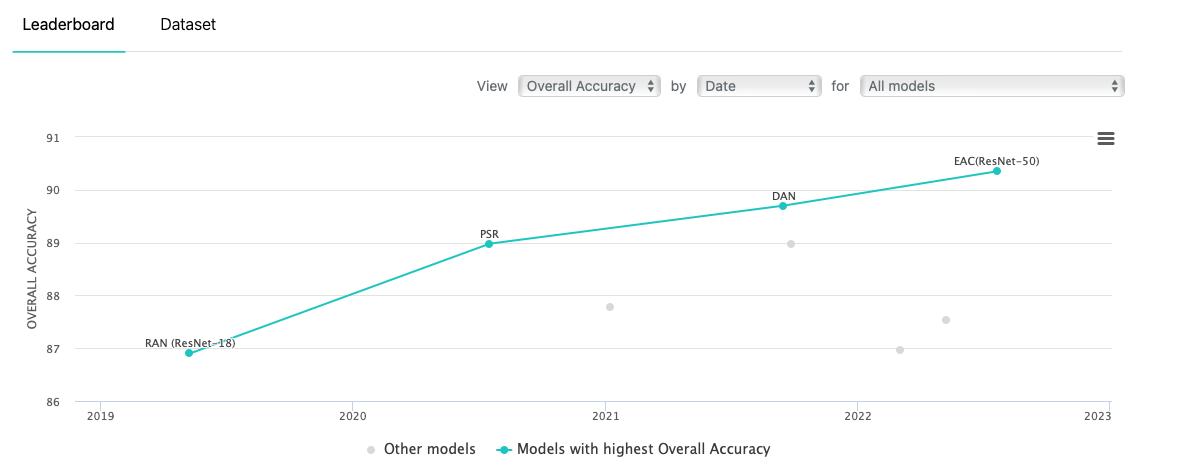

The loss function we used to train our baseline model was cross-entropy with inverse weighting per class. Mathematically,
$$L_{\text{batch}} = \frac{1}{B}\sum_{j=1}^{B} l(y,\hat{y};w)$$
$$l(y,\hat{y};w) = \sum_{k=1}^{K} = -w_{y_j}y_{j,k}\log\text{Softmax}(\hat{y}_j)$$
$$w_k = \frac{1}{N_k^\text{train}}$$

Let's analyze in detail these equations. The first equation is the per-loss batch: we take the mean cross-entropy loss over the predictions in the batch. We call $l(y,\hat{y};w)$ our per-example cross-entropy loss: this is a function of $y$ and $\hat{y}$ and parameterized by the class weights $w$.

The next equation looks at the per-example cross-entropy loss. $y_j$ is a one-hot vector, so the only contribution in this sum is from the correct class $k'$ of the image. For this closs, we punish low probabilitiy predictions. We build the softmax function into our loss since the ResNet18 architecture we implemented outputs raw class scores (i.e. logits). In order to make it a probability distribution, we must use a Softmax.

Finally, we have to account for class imbalance. To do so, we weight the per-example loss by a weight $w_{k'}$. The weight for a class $k'$ is the inverse of the number of examples of class $k'$ in the training set. By doing so, we accomplish two things:
- if two classes $k_1$ and $k_2$ have similar number of training examples, then the weights for these two classes will be similar.
- if one class $k$ has an over-abundance of training examples, then the weight for this class will be smaller, so the model does not overfit to this class.


## Hyperparameter Search
We performed a hyperparameter search before training the baseline model. Due to constraints on GPU, we limited our hyperparameter search to a small subset of variables that we thought would have an important effect on model performance.
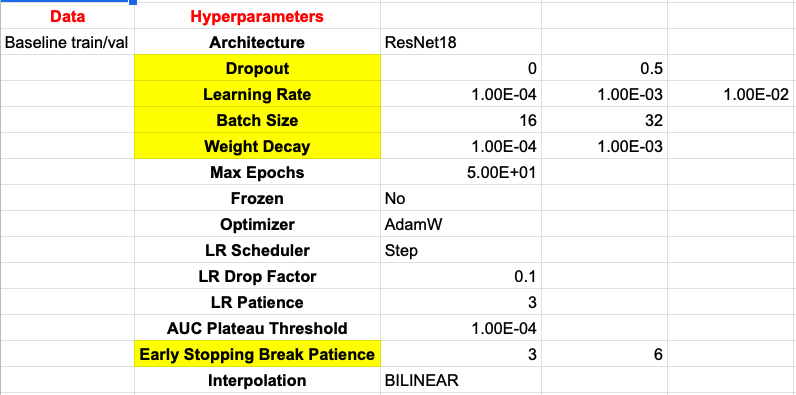
For each hyperparameter setting, we trained the model on the training subset (i.e. the training set derived from a further train/val split on the original training set) and compared performance via one-v-all AUROC on the validation set. After selecting our best hyperparameters, we trained all models using these settings on the original training set.
See https://docs.google.com/spreadsheets/d/1Pju7Ey7Nn2OvxeNtkLw6IVwhof0lohpiXrmB8bmw_EY/edit?usp=sharing for the complete results.

| Hyperparameters           | Best Value |
|-------------------------|-------|
| Dropout                 | 0     |
| Learning Rate           | 0.001 |
| Batch Size              | 32    |
| Weight Decay            | 0.001 |
| Early Stopping Patience | 3     |



## Methods




What methods did you choose? Why did you choose them?

How did you train these methods, and how did you evaluate them? Why?

Which methods were easy/difficult to implement and train? Why?

For each method, what hyperparameters did you evaluate? How sensitive was your model's performance to different hyperparameter settings?

In [ ]:
# Code for training models, or link to your Git repository

In [ ]:
# Show plots of how these models performed during training.
#  For example, plot train loss and train accuracy (or other evaluation metric) on the y-axis,
#  with number of iterations or number of examples on the x-axis.

## Results

Show tables comparing your methods to the baselines.

What about these results surprised you? Why?

Did your models over- or under-fit? How can you tell? What did you do to address these issues?

What does the evaluation of your trained models tell you about your data? How do you expect these models might behave differently on different data?  

In [ ]:
# Show plots or visualizations of your evaluation metric(s) on the train and test sets.
#   What do these plots show about over- or under-fitting?
#   You may borrow from how we visualized results in the Lab homeworks.
#   Are there aspects of your results that are difficult to visualize? Why?

# Discussion

## What you've learned

*Note: you don't have to answer all of these, and you can answer other questions if you'd like. We just want you to demonstrate what you've learned from the project.*

What concepts from lecture/breakout were most relevant to your project? How so?

What aspects of your project did you find most surprising?

What lessons did you take from this project that you want to remember for the next ML project you work on? Do you think those lessons would transfer to other datasets and/or models? Why or why not?

What was the most helpful feedback you received during your presentation? Why?

If you had two more weeks to work on this project, what would you do next? Why?